In [1]:
%load_ext autoreload
%autoreload 2
import os
import ujson
import multiprocessing as mp
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc

from config import *
from openpose_helpers import *
from run_openpose import run_openpose

In [2]:
# Download openpose demo video into current directory
!wget https://github.com/CMU-Perceptual-Computing-Lab/openpose/raw/master/examples/media/video.avi \
    -P openpose_demo/

--2020-06-26 00:25:27--  https://github.com/CMU-Perceptual-Computing-Lab/openpose/raw/master/examples/media/video.avi
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CMU-Perceptual-Computing-Lab/openpose/master/examples/media/video.avi [following]
--2020-06-26 00:25:27--  https://raw.githubusercontent.com/CMU-Perceptual-Computing-Lab/openpose/master/examples/media/video.avi
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.0.133, 151.101.64.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1395096 (1.3M) [video/msvideo]
Saving to: ‘openpose_demo/video.avi’

video.avi           100%[===================>]   1.33M  2.44MB/s    in 0.5s    

2020-06-26 00:25:28 (2.44 MB/s

In [3]:
# DEMO_OUTPUT = os.path.join(OUTPUT, 'openpose_demo')
DEMO_OUTPUT = os.path.join('.', 'openpose_demo')
os.makedirs(DEMO_OUTPUT, exist_ok=True)

In [4]:
# Submit job to run openpose on this video + condense the outputs into one dataframe
demo_vid_path = os.path.join(DEMO_OUTPUT, 'video.avi')
op_output_dir = os.path.join(DEMO_OUTPUT, 'openpose_raw_json')
condensed_output_dir = os.path.join(DEMO_OUTPUT, 'openpose_condensed')

run_openpose(demo_vid_path, op_output_dir, 
             condensed_output_dir=condensed_output_dir, 
             keypoint_scale=3, condense=True, overwrite=False)

Outputs already exist for video ./openpose_demo/video.avi -- aborting...


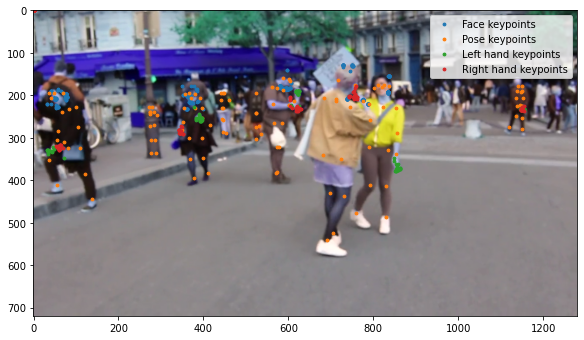

In [5]:
# Sanity check Openpose by pulling a random frame and seeing if keypoints align with
# people's bodies

def get_frame(vid_path, frame):
    cap = cv2.VideoCapture(vid_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    return cap.read()[1]

def sanity_check_op_keypts(vid_path, vid_df_path, keypts_normalized=True):
    """
    Given a vid-level JSON, plot a random frame in the video containing openpose 
    keypoints to sanity-check that the openpose keypoints appear sensible.
    
    Arguments:
    vid_path          -- path to the video to sanity check
    vid_df_path       -- path to the video's Openpose condensed 
                        JSON dataframe to sanity check
    keypts_normalized -- True if keypoints in Openpose outputs are normalized
    (i.e. x and y values in range [0, 1]), else False
    """
    df = pd.read_json(vid_df_path)
    openpose_npy = recover_npy(df)
    rand_frame = np.random.randint(0, len(df))
    img = get_frame(vid_path, rand_frame)
    plt.figure(figsize=(10, img.shape[0]/img.shape[1]*10))
    x_factor = img.shape[1] if keypts_normalized else 1
    y_factor = img.shape[0] if keypts_normalized else 1
    for person in openpose_npy[rand_frame]:
        plt.scatter(person[0, NPY_FACE_START:NPY_FACE_END]*x_factor, 
                    person[1, NPY_FACE_START:NPY_FACE_END]*y_factor, 
                    c='C0', s=8, label='Face keypoints')
        plt.scatter(person[0, NPY_POSE_START:NPY_POSE_END]*x_factor,  
                    person[1, NPY_POSE_START:NPY_POSE_END]*y_factor,  
                    c='C1', s=8, label='Pose keypoints')
        plt.scatter(person[0, NPY_HAND_LEFT_START:NPY_HAND_LEFT_END]*x_factor,   
                    person[1, NPY_HAND_LEFT_START:NPY_HAND_LEFT_END]*y_factor,   
                    c='C2', s=8, label='Left hand keypoints')
        plt.scatter(person[0, NPY_HAND_RIGHT_START:NPY_HAND_RIGHT_END]*x_factor,    
                    person[1, NPY_HAND_RIGHT_START:NPY_HAND_RIGHT_END]*y_factor,    
                    c='C3', s=8, label='Right hand keypoints')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())    
    plt.imshow(img)
    
vid_df_path = os.path.join(condensed_output_dir, 'video.json')
sanity_check_op_keypts(demo_vid_path, vid_df_path, keypts_normalized=True)